In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ed54fa19-4387-d5d1-4f31-90ff4bd34efa)


Dataset Source: https://arxiv.org/abs/1710.06071

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.


In [ ]:
!ls pubmed-rct/

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


We will first of all work on 20k dataset and analyse and apply the results for 200k dataset

In [ ]:
import os
import pathlib

In [ ]:
data_dir = os.path.join('pubmed-rct','PubMed_20k_RCT_numbers_replaced_with_at_sign')

In [ ]:
filenames = os.listdir(data_dir)
filenames

['dev.txt', 'train.txt', 'test.txt']

In [ ]:
test_file = os.path.join(data_dir,filenames[0])
train_file = os.path.join(data_dir,filenames[1])
dev_file = os.path.join(data_dir,filenames[2])

In [ ]:
def make_dictionary(index,target,text,total):
  return {"target":target,"text":text,"Line No.":index,"Total Lines":total}


In [ ]:
def get_data_dict(filename):
  full_list = []
  with open(filename,"r") as f:
    full_list = f.readlines()
  
  new_list = []
  cont_lines = "";
  for i in full_list:
    if(i[:3]=='###'):
      cont_lines = ""
    elif(i=='\n'):
      this_lines = cont_lines.lower().splitlines()
      t = 0
      for line in this_lines:
        x = line.split('\t')
        new_list.append(make_dictionary(t,x[0].strip(),x[1].strip(),len(this_lines)))
        t = t+1
    else:
      cont_lines = cont_lines + i

  return new_list


In [ ]:
train_dict = get_data_dict(train_file)
test_dict = get_data_dict(test_file)
val_dict = get_data_dict(dev_file)

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_dict)
val_df = pd.DataFrame(val_dict)
test_df = pd.DataFrame(test_dict)

In [ ]:
train_df

,target,text,Line No.,Total Lines
0,objective,to investigate the efficacy of @ weeks of dail...,0,12
1,methods,a total of @ patients with primary knee oa wer...,1,12
2,methods,outcome measures included pain reduction and i...,2,12
3,methods,pain was assessed using the visual analog pain...,3,12
4,methods,secondary outcome measures included the wester...,4,12
...,...,...,...,...
180035,results,for the absolute change in percent atheroma vo...,7,12
180036,results,"for pav , a significantly greater percentage o...",8,12
180037,results,both strategies had acceptable side effect pro...,9,12
180038,conclusions,"compared with standard statin monotherapy , th...",10,12


In [ ]:
train_df.target.value_counts()


methods        59353
results        57953
conclusions    27168
background     21727
objective      13839
Name: target, dtype: int64

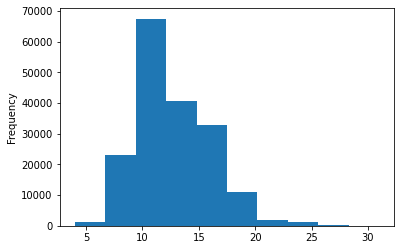

In [ ]:
train_df['Total Lines'].plot.hist();


In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names


(5, array(['background', 'conclusions', 'methods', 'objective', 'results'],
       dtype=object))

In [ ]:
train_text = train_df["text"].tolist()
val_text = val_df["text"].tolist()
test_text = test_df["text"].tolist()

#Model 0 : Naive Model || TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])
model_0.fit(X=train_text, 
            y=train_labels_encoded);

In [ ]:
model_0.score(X=val_text,
              y=val_labels_encoded)

0.6779771161964008

In [ ]:
baseline_preds = model_0.predict(val_text)
baseline_preds

array([2, 2, 4, ..., 4, 4, 2])

In [ ]:
val_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


In [ ]:
def calculate_results(y_true,y_pred):
  model_accuracy = accuracy_score(y_true,y_pred)*100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true,y_pred,average="weighted")
  model_results = {
      "accuracy":model_accuracy,
      "precision":model_precision,
      "recall":model_recall,
      "f1":model_f1
  }

  return model_results

In [ ]:
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)

In [ ]:
baseline_results

{'accuracy': 67.79771161964008,
 'f1': 0.6371863234667444,
 'precision': 0.6775043255859432,
 'recall': 0.6779771161964008}

#Model 1 : Deep Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
import numpy as np

In [ ]:
lengths = [len(i.split()) for i in train_text]

In [ ]:
np.mean(lengths)

26.338269273494777

(array([1.48363e+05, 2.92360e+04, 2.13600e+03, 2.41000e+02, 3.60000e+01,
        2.10000e+01, 5.00000e+00, 2.00000e+00]),
 array([  1.   ,  37.875,  74.75 , 111.625, 148.5  , 185.375, 222.25 ,
        259.125, 296.   ]),
 <a list of 8 Patch objects>)

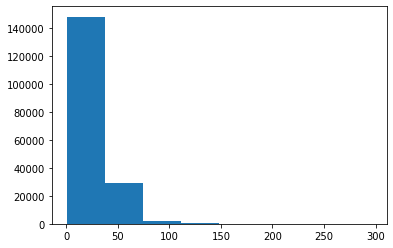

In [ ]:
import matplotlib.pyplot as plt
plt.hist(lengths, bins=8)

In [ ]:
appr_len = int(np.percentile(lengths, 95))
appr_len

55

We will use max_tokens = 68000 as given in the article

In [ ]:
text_vectorizer = TextVectorization(
    max_tokens=68000,
    output_mode="int",
    output_sequence_length=appr_len,
)

In [ ]:
text_vectorizer.adapt(train_text)

In [ ]:
import random
target_sentence = random.choice(train_text)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
test performance at @ and @ months following mailing of the test kit , retrieved from hmo 's computerized database ( @-@ ) .

Length of text: 24

Vectorized text:
[[  128   282    15     3    40   259  7446     4     2   128  5480 10961
     27 21398   123  3939  3725     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
vocab_1 = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(vocab_1)}"), 
print(f"Most common words in the vocabulary: {vocab_1[:5]}")
print(f"Least common words in the vocabulary: {vocab_1[-5:]}")

Number of words in vocabulary: 24854
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aarhus', 'aai', 'aagg', 'aadenosine', 'aacr']


In [ ]:
text_vectorizer.get_config()


{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization_1',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

In [ ]:
from tensorflow.keras import layers

In [ ]:
token_emb = layers.Embedding(input_dim = len(vocab_1),
                             output_dim = 128,
                             mask_zero = True,
                             name = "Token_embedding")

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_text, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_text, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_text, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_emb(text_vectors) 
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 55)               0         
 ectorization)                                                   
                                                                 
 Token_embedding (Embedding)  (None, 55, 24854)        3181312   
                                                                 
 conv1d_2 (Conv1D)           (None, 55, 64)            7953344   
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 5)                 325 

In [ ]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
942/942 [==============================] - 60s 63ms/step - loss: 0.8771 - accuracy: 0.6596 - val_loss: 0.8152 - val_accuracy: 0.6851
Epoch 2/3
942/942 [==============================] - 70s 74ms/step - loss: 0.7816 - accuracy: 0.7002 - val_loss: 0.7861 - val_accuracy: 0.6953
Epoch 3/3
942/942 [==============================] - 60s 63ms/step - loss: 0.7456 - accuracy: 0.7216 - val_loss: 0.7759 - val_accuracy: 0.7080


In [ ]:
model_1.evaluate(valid_dataset)

5627/5627 [==============================] - 107s 19ms/step - loss: 0.7695 - accuracy: 0.7101


[0.7694722414016724, 0.7100644111633301]

In [ ]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

array([[1.5450974e-01, 1.5832557e-01, 2.2153249e-02, 6.5841478e-01,
        6.5966421e-03],
       [8.3022428e-07, 1.7494275e-06, 9.7497720e-01, 5.0634276e-07,
        2.5019826e-02],
       [1.4131469e-02, 1.8364644e-02, 6.9495976e-01, 8.6249113e-03,
        2.6391917e-01],
       ...,
       [6.9364808e-03, 6.6369140e-01, 1.9187879e-02, 2.0795218e-03,
        3.0810478e-01],
       [5.4776573e-01, 3.8129672e-01, 1.4520306e-03, 6.2914386e-02,
        6.5711448e-03],
       [7.3461197e-02, 1.7123634e-01, 4.6415073e-01, 3.5739411e-02,
        2.5541237e-01]], dtype=float32)

In [ ]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(180040,), dtype=int64, numpy=array([3, 2, 2, ..., 1, 0, 2])>

In [ ]:
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 71.00644301266385,
 'f1': 0.7072086123733096,
 'precision': 0.7354292229198456,
 'recall': 0.7100644301266386}

#Model 2 || Using Tensorflow Hub

In [ ]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
inputs = layers.Input(shape=[], dtype=tf.string)
x = tf_hub_embedding_layer(inputs)
outputs = layers.Dense(256, activation="softmax")(x)
outputs = layers.Dense(64, activation="softmax")(x)
# x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(x)
# x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_7 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 256,800,389
Trainable params: 2,565
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_2_history = model_2.fit(train_dataset,
                              epochs=3,
                              validation_data=valid_dataset)

Epoch 1/3
942/942 [==============================] - 74s 77ms/step - loss: 1.1691 - accuracy: 0.5698 - val_loss: 0.9906 - val_accuracy: 0.6380
Epoch 2/3
942/942 [==============================] - 73s 78ms/step - loss: 0.9277 - accuracy: 0.6598 - val_loss: 0.8876 - val_accuracy: 0.6735
Epoch 3/3
942/942 [==============================] - 88s 93ms/step - loss: 0.8609 - accuracy: 0.6825 - val_loss: 0.8472 - val_accuracy: 0.6837


In [ ]:
model_2.evaluate(valid_dataset)

5627/5627 [==============================] - 68s 12ms/step - loss: 0.8472 - accuracy: 0.6837


[0.8472146987915039, 0.6836758255958557]

In [ ]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[0.26246086, 0.42395237, 0.05506829, 0.24054079, 0.01797774],
       [0.00770644, 0.00934687, 0.7724921 , 0.00312663, 0.20732792],
       [0.10851688, 0.2534471 , 0.4534804 , 0.09620309, 0.0883525 ],
       ...,
       [0.17113087, 0.3629791 , 0.16017103, 0.10385787, 0.20186107],
       [0.08128292, 0.3452041 , 0.02703413, 0.0702602 , 0.47621873],
       [0.11186153, 0.09999158, 0.5207904 , 0.16816843, 0.09918801]],
      dtype=float32)

In [ ]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(180040,), dtype=int64, numpy=array([1, 2, 2, ..., 1, 4, 2])>

In [ ]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 68.3675849811153,
 'f1': 0.674020991000538,
 'precision': 0.6766408227805409,
 'recall': 0.683675849811153}

#Model 3 || With Char-level embeddings

In [ ]:
def split_chars(text):
  return " ".join(list(text))

In [ ]:
train_chars = [split_chars(t) for t in train_text]
val_chars = [split_chars(t) for t in val_text]
test_chars = [split_chars(t) for t in test_text]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [ ]:
char_lens = [len(sentence) for sentence in train_text]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

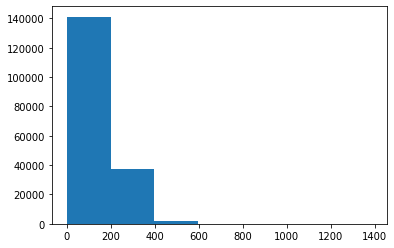

In [ ]:
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [ ]:
char_len = int(np.percentile(char_lens, 95))
char_len

290

In [ ]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
CHAR_TOKENS = len(alphabet) + 2 #To ensure OOV and space
char_vectorizer = TextVectorization(
    max_tokens=CHAR_TOKENS,
    output_mode="int",
    output_sequence_length=char_len,
)

In [ ]:
char_vectorizer.adapt(train_chars)

In [ ]:
vocab_2 = char_vectorizer.get_vocabulary()


In [ ]:
char_vectorizer.get_config()


{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 70,
 'name': 'text_vectorization_1',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 290,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

In [ ]:
char_emb = layers.Embedding(input_dim = len(vocab_2),
                             output_dim = 32,
                             mask_zero = False,
                             name = "Character_embedding")

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
lyr_embeddings = char_emb(char_vectors) 
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(lyr_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs)
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_3.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 288)              0         
 ectorization)                                                   
                                                                 
 Character_embedding (Embedd  (None, 288, 32)          896       
 ing)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 288, 64)           10304     
                                                                 
 global_average_pooling1d_3   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                           

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

In [ ]:
model_3_history = model_3.fit(train_char_dataset,
                              epochs=3,
                              validation_data=val_char_dataset,
                              )

In [ ]:
model_3.evaluate(val_char_dataset)

In [ ]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

In [ ]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

In [ ]:
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

#Model 4 || Using  https://arxiv.org/pdf/1612.05251.pdf as a reference 

In [ ]:
#The characrter embedding par
char_inputs =  layers.Input(shape=[], dtype=tf.string)
x = char_vectorizer(char_inputs)
x = char_emb(x)
char_output = layers.Bidirectional(layers.LSTM(24))(x)
print(char_output.shape)
model_char = tf.keras.Model(char_inputs,char_output)

#The token embedding part
token_inputs = layers.Input(shape=[],dtype=tf.string)
y = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(y)
model_token = tf.keras.Model(token_inputs,token_output)

#Concating them
token_char_concat = layers.Concatenate(name="token_char_hybrid")([model_token.output, 
                                                                  model_char.output])
#Further
z = layers.Dropout(0.5)(token_char_concat)
z = layers.Bidirectional(layers.LSTM(96))(tf.expand_dims(z, axis=1))
z = layers.Dropout(0.5)(z)
final_output = layers.Dense(num_classes,activation="softmax")(z)


model_4 = tf.keras.Model(inputs=[model_token.input, model_char.input],
                         outputs=final_output,
                         name="model_4_token_and_char_embeddings")

(None, 48)


In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 288)         0           ['input_12[0][0]']               
 ization)                                                                                         
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

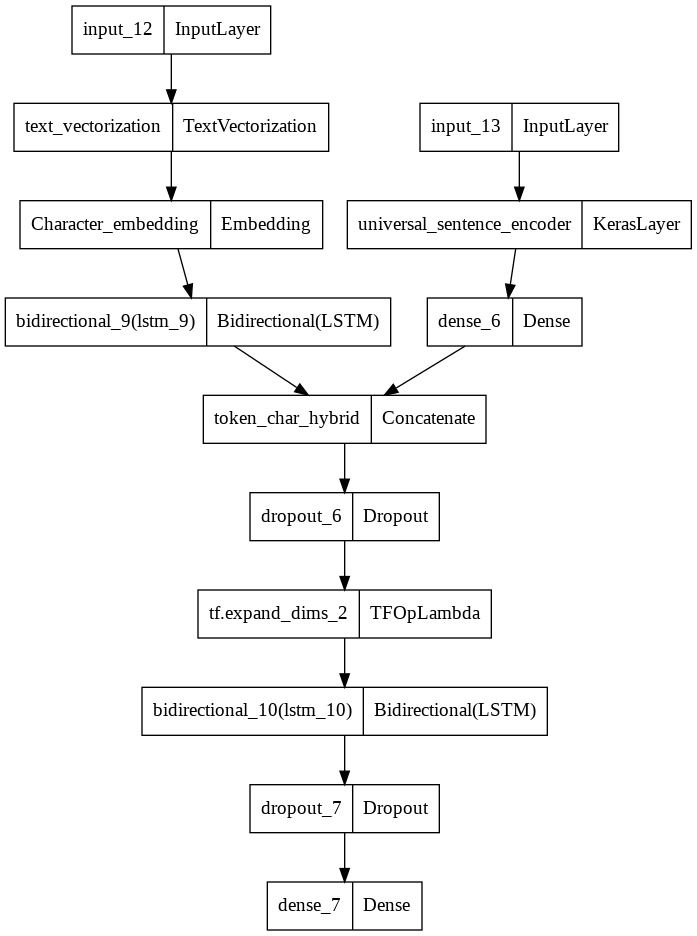

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [ ]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=["accuracy"])

In [ ]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_text, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_text, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              epochs=3,
                              validation_data=val_char_token_dataset)

Epoch 1/3
942/942 [==============================] - 168s 164ms/step - loss: 0.9106 - accuracy: 0.6410 - val_loss: 0.7600 - val_accuracy: 0.7083
Epoch 2/3
942/942 [==============================] - 146s 156ms/step - loss: 0.7689 - accuracy: 0.7028 - val_loss: 0.7118 - val_accuracy: 0.7273
Epoch 3/3
942/942 [==============================] - 148s 157ms/step - loss: 0.7239 - accuracy: 0.7227 - val_loss: 0.6875 - val_accuracy: 0.7375


In [ ]:
model_4.evaluate(val_char_token_dataset)

In [ ]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

In [ ]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

In [ ]:
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

#Model 5 || Also including positional embeddings

In [ ]:
train_df

,target,text,Line No.,Total Lines
0,objective,to investigate the efficacy of @ weeks of dail...,0,12
1,methods,a total of @ patients with primary knee oa wer...,1,12
2,methods,outcome measures included pain reduction and i...,2,12
3,methods,pain was assessed using the visual analog pain...,3,12
4,methods,secondary outcome measures included the wester...,4,12
...,...,...,...,...
180035,results,for the absolute change in percent atheroma vo...,7,12
180036,results,"for pav , a significantly greater percentage o...",8,12
180037,results,both strategies had acceptable side effect pro...,9,12
180038,conclusions,"compared with standard statin monotherapy , th...",10,12


In [ ]:
train_df["Line No."].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: Line No., dtype: int64

In [ ]:
int(np.percentile(train_df["Line No."], 98))

15

In [ ]:
train_df["Total Lines"].value_counts()

12    24468
11    23639
13    22113
10    19400
14    18438
15    14610
9     12285
16    10768
8      7464
17     7429
18     5202
7      3353
19     3344
20     2480
21     1281
6      1146
22      770
23      759
24      264
5       215
25      200
26      182
27       81
29       58
4        32
31       31
28       28
Name: Total Lines, dtype: int64

In [ ]:
int(np.percentile(train_df["Total Lines"], 97))


20

In [ ]:
train_line_numbers_one_hot = tf.one_hot(train_df["Line No."].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["Line No."].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["Line No."].to_numpy(), depth=15)

In [ ]:
train_line_total_one_hot = tf.one_hot(train_df["Total Lines"].to_numpy(), depth=20)
val_line_total_one_hot = tf.one_hot(val_df["Total Lines"].to_numpy(), depth=20)
test_line_total_one_hot = tf.one_hot(test_df["Total Lines"].to_numpy(), depth=20)

In [ ]:
train_line_total_one_hot

<tf.Tensor: shape=(180040, 20), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
#The characrter embedding part
char_inputs =  layers.Input(shape=[], dtype=tf.string)
x = char_vectorizer(char_inputs)
x = char_emb(x)
char_output = layers.Bidirectional(layers.LSTM(24))(x)
# print(char_output.shape)
model_char = tf.keras.Model(char_inputs,char_output)

#The token embedding part
token_inputs = layers.Input(shape=[],dtype=tf.string)
y = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(y)
model_token = tf.keras.Model(token_inputs,token_output)

#Concating them
token_char_concat = layers.Concatenate(name="token_char_hybrid")([model_token.output, 
                                                                  model_char.output])
print(token_char_concat)

#Line Numbers
line_no_input = layers.Input(shape=(15,),dtype=tf.int32,name="line_no_input")
a = layers.Dense(32,activation="relu")(line_no_input)
model_line_num = tf.keras.Model(line_no_input,a)

#Total Lines
line_total_input = layers.Input(shape=(20,),dtype=tf.int32,name="line_total_input")
b = layers.Dense(32,activation="relu")(line_total_input)
model_line_total = tf.keras.Model(line_total_input,b)

#Further
z = layers.Dropout(0.5)(token_char_concat)
z = layers.Bidirectional(layers.LSTM(96))(tf.expand_dims(z, axis=1))
z = layers.Dropout(0.5)(z)
z = layers.Concatenate(name="tri_cooncate")([z,model_line_num.output,model_line_total.output])
print(z.shape)
z = layers.Dense(64,activation="relu")(z)
final_output = layers.Dense(num_classes,activation="softmax")(z)

model_5 = tf.keras.Model(inputs=[model_line_num.input,
                                 model_line_total.input,
                                 model_token.input, 
                                 model_char.input],
                         outputs=final_output)

KerasTensor(type_spec=TensorSpec(shape=(None, 176), dtype=tf.float32, name=None), name='token_char_hybrid/concat:0', description="created by layer 'token_char_hybrid'")
(None, 256)


In [ ]:
model_5.summary()


Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 290)         0           ['input_12[0][0]']               
 orization)                                                                                       
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['input_13[0][0]']        

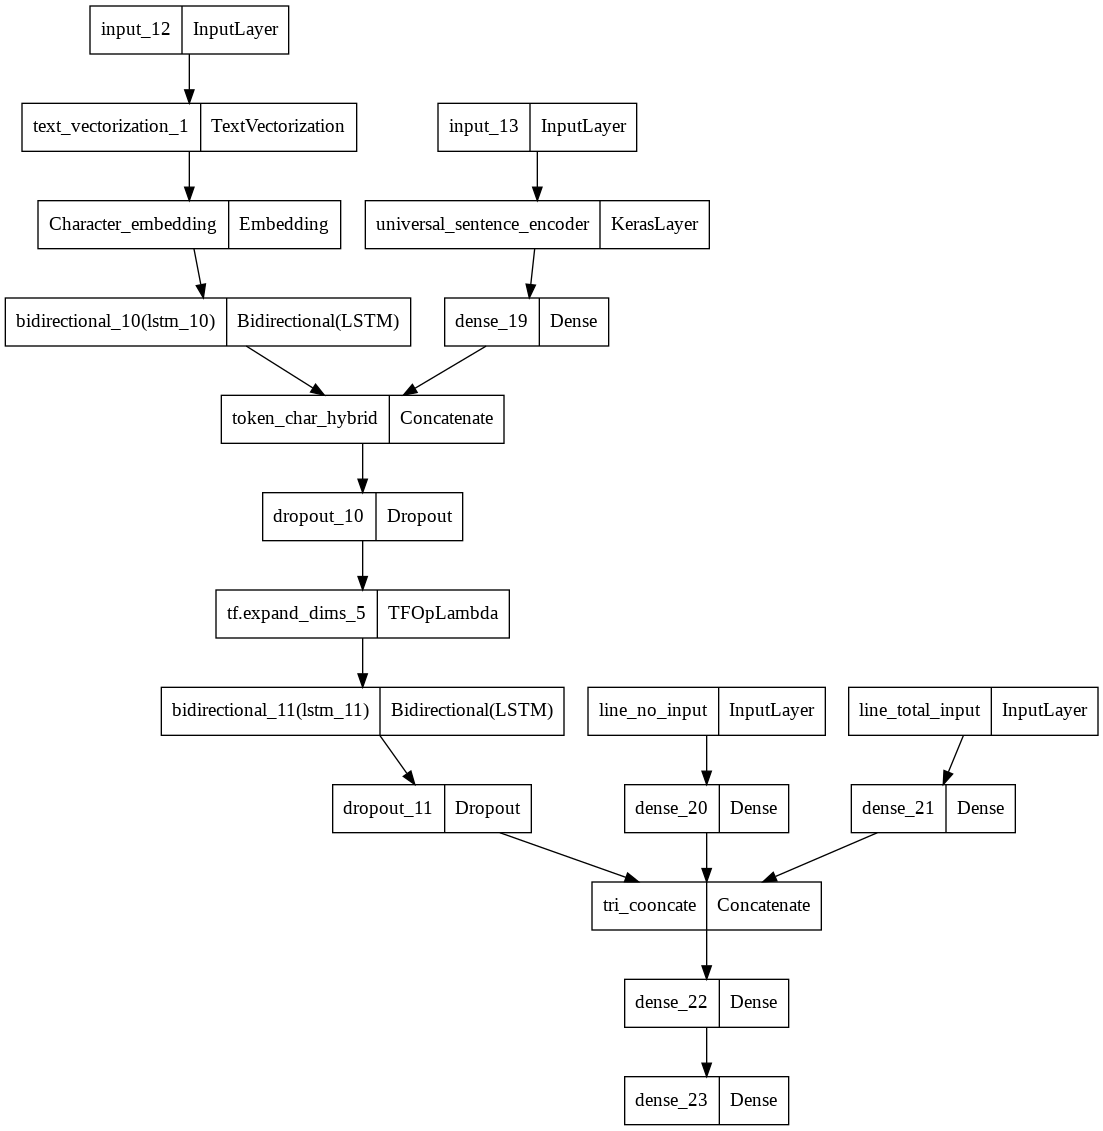

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [ ]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:

train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, 
                                                                train_line_total_one_hot, 
                                                                train_text,
                                                                train_chars)) 
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) 
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) 
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_line_total_one_hot,
                                                              val_text,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,)

Epoch 1/3
5627/5627 [==============================] - 279s 47ms/step - loss: 0.9288 - accuracy: 0.8264 - val_loss: 0.8780 - val_accuracy: 0.8570
Epoch 2/3
5627/5627 [==============================] - 212s 38ms/step - loss: 0.8801 - accuracy: 0.8565 - val_loss: 0.8651 - val_accuracy: 0.8659
Epoch 3/3
5627/5627 [==============================] - 211s 37ms/step - loss: 0.8702 - accuracy: 0.8632 - val_loss: 0.8625 - val_accuracy: 0.8672


In [ ]:
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

942/942 [==============================] - 21s 21ms/step


array([[0.3972029 , 0.04230082, 0.05203917, 0.47031343, 0.03814377],
       [0.19014622, 0.05524836, 0.47991174, 0.1947731 , 0.07992057],
       [0.03671242, 0.03730511, 0.82204837, 0.04555743, 0.05837671],
       ...,
       [0.04898915, 0.08357614, 0.02222307, 0.05198336, 0.79322827],
       [0.05633762, 0.1187445 , 0.0184689 , 0.04966578, 0.7567832 ],
       [0.03959231, 0.8472929 , 0.02958043, 0.02823959, 0.05529481]],
      dtype=float32)

In [ ]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 2, 2, ..., 4, 4, 1])>

In [ ]:
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 86.72307947569273,
 'f1': 0.8641641930849575,
 'precision': 0.8692541648813193,
 'recall': 0.8672307947569272}

Performance on Test Data

In [ ]:
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                            test_line_total_one_hot,
                                                              test_text,
                                                              test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

In [ ]:
model_5_pred_probs_test = model_5.predict(test_pos_char_token_dataset, verbose=1)
model_5_pred_probs_test

945/945 [==============================] - 19s 21ms/step


array([[0.6069266 , 0.04386688, 0.04225257, 0.26393947, 0.04301443],
       [0.63006747, 0.05056264, 0.04471534, 0.23350145, 0.0411531 ],
       [0.36196968, 0.03270834, 0.08526581, 0.4678674 , 0.05218875],
       ...,
       [0.0363579 , 0.05194849, 0.03157697, 0.03815534, 0.8419613 ],
       [0.05697994, 0.6403526 , 0.03259085, 0.05813249, 0.21194415],
       [0.09238573, 0.7981214 , 0.03931871, 0.03459772, 0.03557639]],
      dtype=float32)

In [ ]:
model_5_preds_test = tf.argmax(model_5_pred_probs_test, axis=1)
model_5_preds_test

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
model_5_results_test = calculate_results(y_true=test_labels_encoded,
                                    y_pred=model_5_preds_test)
model_5_results_test

{'accuracy': 87.02502316960148,
 'f1': 0.8671902625721074,
 'precision': 0.8733540996937813,
 'recall': 0.8702502316960148}